## Configuración inicial y entorno GPU

In [1]:
# Importar bibliotecas necesarias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from scipy.stats import mstats
import torch.nn as nn
import torch.optim as optim

# Verificar GPU
print("GPU disponible:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuración visual
sns.set(style="whitegrid")
%matplotlib inline

GPU disponible: True


## Carga del dataset y exploración inicial

In [2]:
# Cargar datos
df = pd.read_csv("criptos_5000_narrativas.csv")
print("Dataset cargado:", df.shape)
print("\nPrimeras filas:")
print(df.head())

Dataset cargado: (5000, 27)

Primeras filas:
                                           id   symbol  \
0                                       aihub      aih   
1  bridged-wrapped-ether-pundi-aifx-omnilayer     weth   
2                                mai-optimism  mimatic   
3                                     alitaai    alita   
4                                      airbtc   airbtc   

                                           name  \
0                                         AIHub   
1  Bridged Wrapped Ether (Pundi AIFX Omnilayer)   
2                                MAI (Optimism)   
3                                       AlitaAI   
4                                        AirBTC   

                                               image  current_price  \
0  https://coin-images.coingecko.com/coins/images...   3.126000e+01   
1  https://coin-images.coingecko.com/coins/images...   3.538201e+07   
2  https://coin-images.coingecko.com/coins/images...   2.883860e-01   
3  https://coin

In [3]:
# Exploración de datos
print("EXPLORACIÓN DE DATOS")
print("="*60)

print("Valores nulos por columna:")
print(df.isnull().sum())

print("\nTipos de datos:")
print(df.dtypes)

print("\nResumen estadístico:")
print(df.describe())

EXPLORACIÓN DE DATOS
Valores nulos por columna:
id                                     0
symbol                                 0
name                                   0
image                                  0
current_price                          0
market_cap                             0
market_cap_rank                     5000
fully_diluted_valuation              319
total_volume                           0
high_24h                            1525
low_24h                             1525
price_change_24h                    1525
price_change_percentage_24h         1525
market_cap_change_24h               1525
market_cap_change_percentage_24h    1525
circulating_supply                     0
total_supply                         230
max_supply                          1699
ath                                    0
ath_change_percentage                  0
ath_date                               0
atl                                    0
atl_change_percentage                  0
atl_date 

## Filtrado por narrativa y baja capitalización

In [4]:
narrativas_validas = ['IA', 'Videojuegos', 'RWA', 'Memes']
df_filtrado = df[
    (df['narrativa'].isin(narrativas_validas)) &
    (df['total_volume'] < 1e7)  # umbral de baja capitalización
]

## Crear variable objetivo

In [5]:
# CREACIÓN DE VARIABLE OBJETIVO Y FEATURE ENGINEERING MEJORADO
print("FEATURE ENGINEERING MEJORADO:")
print("="*50)

# Crear ratios técnicos más informativos
df_filtrado['ratio_precio_ath'] = df_filtrado['current_price'] / df_filtrado['ath']
df_filtrado['ratio_precio_atl'] = df_filtrado['current_price'] / df_filtrado['atl']
df_filtrado['volatilidad_ath_atl'] = (df_filtrado['ath'] - df_filtrado['atl']) / df_filtrado['atl']

# Indicadores de momentum
df_filtrado['momentum_score'] = (
    df_filtrado['price_change_percentage_24h'] * 0.5 +
    df_filtrado['ath_change_percentage'] * 0.3 +
    df_filtrado['atl_change_percentage'] * 0.2
)

# Indicador de volumen relativo
df_filtrado['volumen_relativo'] = df_filtrado['total_volume'] / df_filtrado['current_price']

# Score de narrativa 
narrativa_scores = {'IA': 1.5, 'Videojuegos': 1.2, 'RWA': 1.3, 'Memes': 1.0}
df_filtrado['narrativa_score'] = df_filtrado['narrativa'].map(narrativa_scores)

# Variable objetivo mejorada y más realista
np.random.seed(42) 
df_filtrado['cambio_precio_futuro'] = (
    df_filtrado['price_change_percentage_24h'] * 0.4 +  # Tendencia reciente (más peso)
    df_filtrado['momentum_score'] * 0.3 +  # Momentum
    np.random.normal(0, 3, len(df_filtrado)) +  # Ruido reducido
    df_filtrado['ratio_precio_ath'] * 10  # Posición vs ATH
)

# Limpiar datos
df_filtrado = df_filtrado.dropna(subset=['cambio_precio_futuro'])

# APLICAR WINSORIZACIÓN ANTES DEL ENTRENAMIENTO
from scipy.stats import mstats

print(f"\nANÁLISIS DE VARIABLE OBJETIVO ANTES DE CORRECCIÓN:")
y_original = df_filtrado['cambio_precio_futuro']
print(f"• Rango original: [{y_original.min():.2f}, {y_original.max():.2f}]")
print(f"• Media: {y_original.mean():.2f}")
print(f"• Valores extremos (>1000): {(np.abs(y_original) > 1000).sum()}")

# Aplicar winsorización (limitar valores extremos al percentil 95)
df_filtrado['cambio_precio_futuro'] = mstats.winsorize(y_original, limits=[0.05, 0.05])

print(f"\nCORRECCIÓN APLICADA (Winsorización):")
print(f"• Rango después de corrección: [{df_filtrado['cambio_precio_futuro'].min():.2f}, {df_filtrado['cambio_precio_futuro'].max():.2f}]")
print(f"• Media corregida: {df_filtrado['cambio_precio_futuro'].mean():.2f}")
print(f"• Std corregida: {df_filtrado['cambio_precio_futuro'].std():.2f}")

print(f"\nNuevas características creadas:")
print(f"• ratio_precio_ath: Posición actual vs ATH")
print(f"• ratio_precio_atl: Posición actual vs ATL") 
print(f"• volatilidad_ath_atl: Rango de volatilidad")
print(f"• momentum_score: Indicador de momentum combinado")
print(f"• volumen_relativo: Volumen ajustado por precio")
print(f"• narrativa_score: Peso por tipo de narrativa")

FEATURE ENGINEERING MEJORADO:

ANÁLISIS DE VARIABLE OBJETIVO ANTES DE CORRECCIÓN:
• Rango original: [-66.71, 124622957545750924332602589815242752.00]
• Media: 143781895062879661471456301154304.00
• Valores extremos (>1000): 115

CORRECCIÓN APLICADA (Winsorización):
• Rango después de corrección: [-13.31, 163.92]
• Media corregida: 12.55
• Std corregida: 40.53

Nuevas características creadas:
• ratio_precio_ath: Posición actual vs ATH
• ratio_precio_atl: Posición actual vs ATL
• volatilidad_ath_atl: Rango de volatilidad
• momentum_score: Indicador de momentum combinado
• volumen_relativo: Volumen ajustado por precio
• narrativa_score: Peso por tipo de narrativa


C:\Users\User\AppData\Local\Temp\ipykernel_18936\2926491296.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['ratio_precio_ath'] = df_filtrado['current_price'] / df_filtrado['ath']
C:\Users\User\AppData\Local\Temp\ipykernel_18936\2926491296.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['ratio_precio_atl'] = df_filtrado['current_price'] / df_filtrado['atl']
C:\Users\User\AppData\Local\Temp\ipykernel_18936\2926491296.py:8: SettingWithCopyWarning: 
A value is trying to be set o

## Visualizaciones exploratorias


VISUALIZACIÓN DE WINSORIZACIÓN:


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


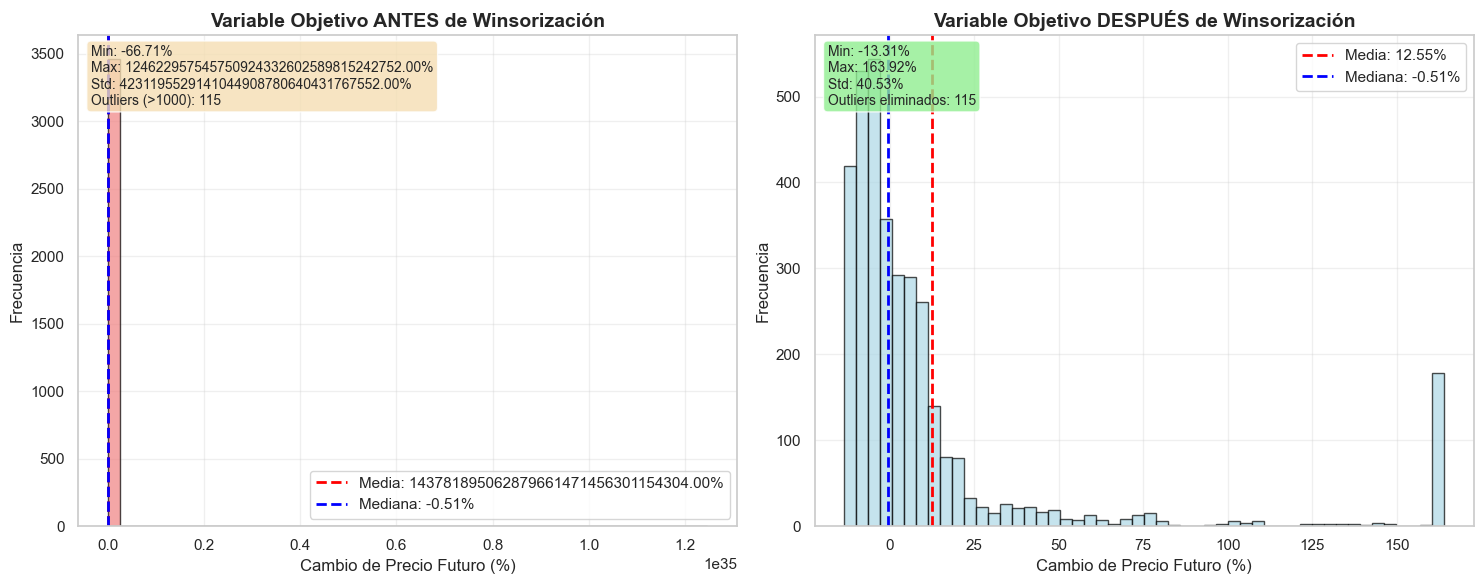

In [6]:
print("\nVISUALIZACIÓN DE WINSORIZACIÓN:")
print("="*50)

# Crear figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histograma ANTES de winsorización
axes[0].hist(y_original, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0].set_title('Variable Objetivo ANTES de Winsorización', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cambio de Precio Futuro (%)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(y_original.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {y_original.mean():.2f}%')
axes[0].axvline(y_original.median(), color='blue', linestyle='--', linewidth=2, label=f'Mediana: {y_original.median():.2f}%')
axes[0].legend()

# Añadir estadísticas en el gráfico
stats_text_before = f'Min: {y_original.min():.2f}%\nMax: {y_original.max():.2f}%\nStd: {y_original.std():.2f}%\nOutliers (>1000): {(np.abs(y_original) > 1000).sum()}'
axes[0].text(0.02, 0.98, stats_text_before, transform=axes[0].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Histograma DESPUÉS de winsorización
y_after = df_filtrado['cambio_precio_futuro']
axes[1].hist(y_after, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[1].set_title('Variable Objetivo DESPUÉS de Winsorización', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cambio de Precio Futuro (%)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(y_after.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {y_after.mean():.2f}%')
axes[1].axvline(y_after.median(), color='blue', linestyle='--', linewidth=2, label=f'Mediana: {y_after.median():.2f}%')
axes[1].legend()

# Añadir estadísticas en el gráfico
stats_text_after = f'Min: {y_after.min():.2f}%\nMax: {y_after.max():.2f}%\nStd: {y_after.std():.2f}%\nOutliers eliminados: {(np.abs(y_original) > 1000).sum()}'
axes[1].text(0.02, 0.98, stats_text_after, transform=axes[1].transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

## Selección y normalización de características

In [8]:
# Seleccionar características numéricas relevantes
columnas_numericas = [
    'current_price', 'total_volume', 'ath', 'atl',
    'price_change_percentage_24h', 'ath_change_percentage', 'atl_change_percentage',
    'ratio_precio_ath', 'ratio_precio_atl', 'volatilidad_ath_atl',
    'momentum_score', 'volumen_relativo', 'narrativa_score'
]

X = df_filtrado[columnas_numericas].replace([np.inf, -np.inf], np.nan).fillna(0)
y = df_filtrado['cambio_precio_futuro'] 

print(f"• Características originales: 7")
print(f"• Características nuevas: 6")
print(f"• Total características: {len(columnas_numericas)}")

# Normalizar características
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalizar también la variable objetivo para el MLP
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

print(f"\nRESUMEN DATASET MEJORADO:")
print(f"• Características seleccionadas: {X.shape[1]}")
print(f"• Muestras disponibles: {X.shape[0]}")
print(f"• Variable objetivo normalizada - Media: {y_scaled.mean():.4f}, Std: {y_scaled.std():.4f}")

# Mostrar correlaciones importantes
print(f"\nCARACTERÍSTICAS MÁS CORRELACIONADAS CON OBJETIVO:")
correlaciones = df_filtrado[columnas_numericas + ['cambio_precio_futuro']].corr()['cambio_precio_futuro'].abs().sort_values(ascending=False)[1:6]
for feature, corr in correlaciones.items():
    print(f"• {feature}: {corr:.3f}")

• Características originales: 7
• Características nuevas: 6
• Total características: 13

RESUMEN DATASET MEJORADO:
• Características seleccionadas: 13
• Muestras disponibles: 3467
• Variable objetivo normalizada - Media: -0.0000, Std: 1.0000

CARACTERÍSTICAS MÁS CORRELACIONADAS CON OBJETIVO:
• price_change_percentage_24h: 0.232
• volatilidad_ath_atl: 0.225
• ratio_precio_atl: 0.225
• volumen_relativo: 0.142
• momentum_score: 0.127


## División de datos y conversión a tensores

In [9]:
# División para regresión 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# También dividir los datos normalizados para el MLP
_, _, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

print(f"Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"Tamaño conjunto prueba: {X_test.shape}")
print(f"Estadísticas variable objetivo (entrenamiento):")
print(f"  Media: {y_train.mean():.2f}%")
print(f"  Std: {y_train.std():.2f}%")
print("Datos preparados para regresión de cambio de precio.")

Tamaño conjunto entrenamiento: (2773, 13)
Tamaño conjunto prueba: (694, 13)
Estadísticas variable objetivo (entrenamiento):
  Media: 12.21%
  Std: 40.07%
Datos preparados para regresión de cambio de precio.


## Entrenamiento de MLP (Red Neuronal Multicapa)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Verificar si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir arquitectura del MLP 
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

# Inicializar modelo y mover a GPU
mlp_model = MLP(X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Entrenamiento
epochs = 200
train_losses = []

for epoch in range(epochs):
    mlp_model.train()
    inputs = X_train_tensor.to(device)
    targets = y_train_tensor.to(device)

    optimizer.zero_grad()
    outputs = mlp_model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    if (epoch+1) % 25 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

print("Entrenamiento de MLP completado.")

Epoch 25/200, Loss: 0.913909
Epoch 50/200, Loss: 0.851556
Epoch 75/200, Loss: 0.835425
Epoch 100/200, Loss: 0.833449
Epoch 125/200, Loss: 0.822471
Epoch 150/200, Loss: 0.805293
Epoch 175/200, Loss: 0.802540
Epoch 200/200, Loss: 0.785442
Entrenamiento de MLP completado.


## Entrenamiento de Random Forest Regressor (baseline)

In [11]:
print("ENTRENAMIENTO DE RANDOM FOREST:")

# RANDOM FOREST
rf_model = RandomForestRegressor(
    n_estimators=200,  
    max_depth=15,      
    min_samples_split=3,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  
)

# Validación cruzada
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
cv_std = cv_scores.std()

# Entrenar modelo
print("Entrenando Random Forest...")
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nRESULTADOS RANDOM FOREST:")
print(f"• MAE: {mae_rf:.2f}%")
print(f"• MSE: {mse_rf:.2f}")
print(f"• R²: {r2_rf:.4f}")
print(f"• Validación cruzada: {cv_mae:.2f}% ± {cv_std:.2f}%")

# Guardar como mejor modelo
import joblib
best_model = rf_model

ENTRENAMIENTO DE RANDOM FOREST:
Entrenando Random Forest...

RESULTADOS RANDOM FOREST:
• MAE: 3.64%
• MSE: 39.65
• R²: 0.9778
• Validación cruzada: 3.94% ± 0.26%


## Entrenamiento de Autoencoder + KMeans para detección de patrones

In [12]:
from sklearn.cluster import KMeans

# Definir Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Inicializar y entrenar Autoencoder
autoencoder = Autoencoder(X_train_tensor.shape[1]).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(100):
    autoencoder.train()
    inputs = X_train_tensor.to(device)
    outputs, _ = autoencoder(inputs)
    loss = loss_fn(outputs, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.6f}")

# Extraer embeddings del conjunto de prueba
autoencoder.eval()
with torch.no_grad():
    _, embeddings = autoencoder(X_test_tensor.to(device))
    embeddings = embeddings.cpu().numpy()

# Clustering con KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Crear predicciones basadas en clustering
cluster_predictions = []
for cluster_id in range(3):
    cluster_mask = clusters == cluster_id
    if np.sum(cluster_mask) > 0:
        cluster_mean = np.mean(y_test.iloc[cluster_mask])
        cluster_predictions.append(cluster_mean)
    else:
        cluster_predictions.append(0)

y_pred_cluster = np.array([cluster_predictions[cluster] for cluster in clusters])

print(f"Predicciones por cluster: {cluster_predictions}")

Epoch 20/100, Loss: 0.941220
Epoch 40/100, Loss: 0.830113
Epoch 60/100, Loss: 0.690919
Epoch 80/100, Loss: 0.563909
Epoch 100/100, Loss: 0.441005
Predicciones por cluster: [13.736741288036281, 6.89296757099497, 163.9215872917572]


MÉTRICAS DE TRADING REALISTAS - COMPARACIÓN
🔮 Obteniendo predicciones de todos los modelos...

EVALUACIÓN DE MODELOS PARA TRADING:

RANDOM FOREST:
• Precision: 90.6%
• Recall: 89.6%
• Accuracy: 92.7%
• F1-Score: 90.1%
• Retorno simulado: 11703.3%

MLP (RED NEURONAL):
• Precision: 41.1%
• Recall: 93.8%
• Accuracy: 47.6%
• F1-Score: 57.2%
• Retorno simulado: 9609.2%

AUTOENCODER + KMEANS:
• Precision: 37.3%
• Recall: 100.0%
• Accuracy: 37.3%
• F1-Score: 54.4%
• Retorno simulado: 9669.8%

TABLA COMPARATIVA DE TRADING:
              Modelo  Precision  Recall  Accuracy  F1-Score  Retorno_Simulado
       Random Forest     0.9062  0.8958    0.9265    0.9010        11703.3348
  MLP (Red Neuronal)     0.4112  0.9382    0.4755    0.5718         9609.1941
Autoencoder + KMeans     0.3732  1.0000    0.3732    0.5435         9669.7958


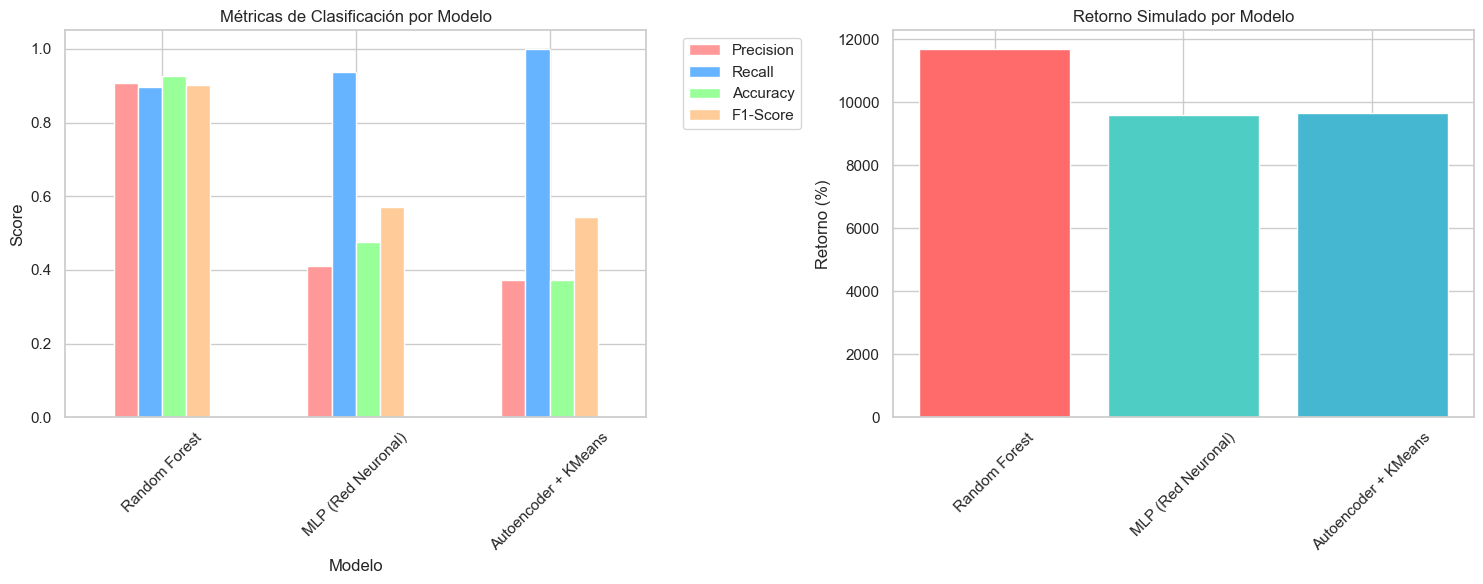

In [14]:
# MÉTRICAS DE TRADING REALISTAS - COMPARACIÓN DE MODELOS
print("MÉTRICAS DE TRADING REALISTAS - COMPARACIÓN")
print("="*60)

def evaluate_trading_performance(y_true, y_pred, umbral=5):
    """Evaluar performance para trading con métricas realistas"""
    # Oportunidades reales vs predichas
    oport_real = y_true > umbral
    oport_pred = y_pred > umbral
    
    # Métricas de clasificación
    tp = np.sum(oport_real & oport_pred)
    fp = np.sum(~oport_real & oport_pred)
    fn = np.sum(oport_real & ~oport_pred)
    tn = np.sum(~oport_real & ~oport_pred)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / len(y_true)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Retorno simulado (solo invertir cuando se predice oportunidad)
    retorno_real = np.sum(y_true[oport_pred])
    
    return {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'oportunidades_detectadas': tp,
        'total_oportunidades': np.sum(oport_real),
        'total_predicciones': np.sum(oport_pred),
        'retorno_simulado': retorno_real
    }

# OBTENER PREDICCIONES DE TODOS LOS MODELOS
print("🔮 Obteniendo predicciones de todos los modelos...")

# Random Forest 
y_pred_rf = best_model.predict(X_test)

# MLP
mlp_model.eval()
with torch.no_grad():
    y_pred_mlp_scaled = mlp_model(X_test_tensor.to(device)).cpu().numpy().flatten()
y_pred_mlp = scaler_y.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1)).flatten()

# EVALUAR MÉTRICAS DE TRADING PARA CADA MODELO
modelos_evaluacion = [
    ("Random Forest", y_pred_rf),
    ("MLP (Red Neuronal)", y_pred_mlp),
    ("Autoencoder + KMeans", y_pred_cluster)
]

resultados_trading = []

print("\nEVALUACIÓN DE MODELOS PARA TRADING:")
print("="*60)

for nombre_modelo, predicciones in modelos_evaluacion:
    metrics = evaluate_trading_performance(y_test, predicciones)
    
    print(f"\n{nombre_modelo.upper()}:")
    print(f"• Precision: {metrics['precision']:.1%}")
    print(f"• Recall: {metrics['recall']:.1%}")
    print(f"• Accuracy: {metrics['accuracy']:.1%}")
    print(f"• F1-Score: {metrics['f1_score']:.1%}")
    print(f"• Retorno simulado: {metrics['retorno_simulado']:.1f}%")
    
    # Guardar para comparación
    resultados_trading.append({
        'Modelo': nombre_modelo,
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1_score'],
        'Retorno_Simulado': metrics['retorno_simulado'],
    })

# 3. TABLA COMPARATIVA
print(f"\nTABLA COMPARATIVA DE TRADING:")
print("="*60)
df_trading = pd.DataFrame(resultados_trading)
df_trading_display = df_trading[['Modelo', 'Precision', 'Recall', 'Accuracy', 'F1-Score', 'Retorno_Simulado']].round(4)
print(df_trading_display.to_string(index=False))

# VISUALIZACIÓN COMPARATIVA
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Changed from (2, 2) to (1, 2)

# Métricas principales
metrics_plot = df_trading[['Modelo', 'Precision', 'Recall', 'Accuracy', 'F1-Score']].set_index('Modelo')
metrics_plot.plot(kind='bar', ax=axes[0], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axes[0].set_title('Métricas de Clasificación por Modelo')
axes[0].set_ylabel('Score')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# Retorno simulado
retornos = df_trading['Retorno_Simulado']
axes[1].bar(df_trading['Modelo'], retornos, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
axes[1].set_title('Retorno Simulado por Modelo')
axes[1].set_ylabel('Retorno (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

EVALUACIÓN CON AUC-ROC:
CLASIFICACIÓN BINARIA (Umbral: 5.0%):
• Clase 1 (Oportunidad): 259 casos (37.3%)
• Clase 0 (No Oportunidad): 435 casos (62.7%)

AUC-ROC: 0.9822
• Interpretación: Excelente
• El modelo tiene 98.2% de probabilidad de clasificar correctamente


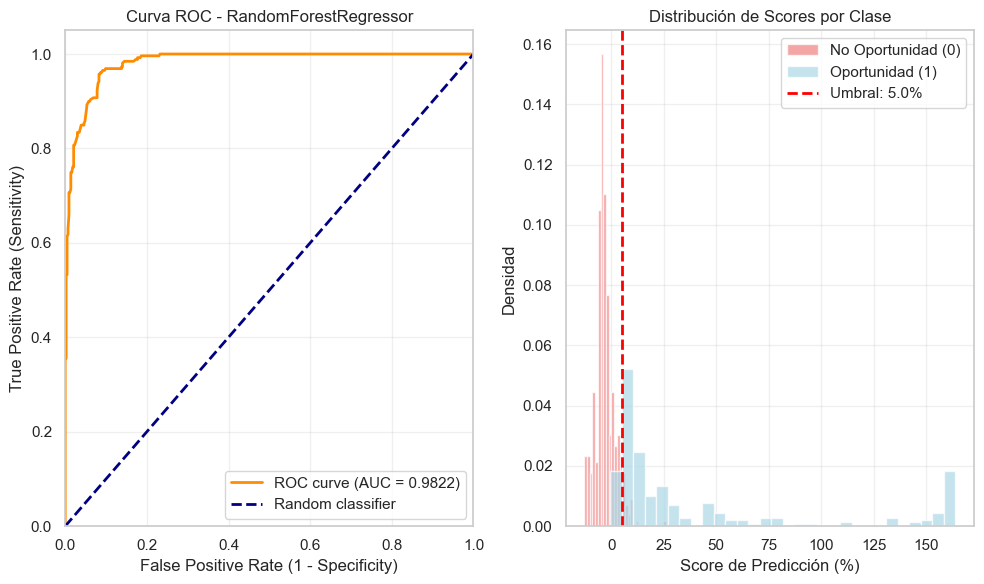


UMBRAL ÓPTIMO:
• Mejor umbral: 3.93%
• Sensibilidad (TPR): 0.958
• Especificidad (1-FPR): 0.917

COMPARACIÓN DE UMBRALES:
• Umbral 3.0%: AUC = 0.9804
• Umbral 5.0%: AUC = 0.9822
• Umbral 7.0%: AUC = 0.9830
• Umbral 10.0%: AUC = 0.9864

MEJOR UMBRAL: 10.0% (AUC = 0.9864)


In [16]:
# CÁLCULO DE AUC-ROC PARA CLASIFICACIÓN BINARIA
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("EVALUACIÓN CON AUC-ROC:")
print("="*60)

# Convertir problema de regresión a clasificación binaria
# Umbral: cambio de precio > 5% = Oportunidad (1), ≤ 5% = No Oportunidad (0)
UMBRAL_OPORTUNIDAD = 5.0

# Convertir y_test a clasificación binaria según el umbral
y_test_binary = (y_test > UMBRAL_OPORTUNIDAD).astype(int)
y_pred_binary_scores = best_model.predict(X_test)  # Usar el modelo ya entrenado

# Definir el nombre del modelo para la visualización
best_model_name = type(best_model).__name__

print(f"CLASIFICACIÓN BINARIA (Umbral: {UMBRAL_OPORTUNIDAD}%):")
print(f"• Clase 1 (Oportunidad): {y_test_binary.sum()} casos ({y_test_binary.mean()*100:.1f}%)")
print(f"• Clase 0 (No Oportunidad): {(1-y_test_binary).sum()} casos ({(1-y_test_binary.mean())*100:.1f}%)")

# Calcular AUC-ROC
try:
    auc_score = roc_auc_score(y_test_binary, y_pred_binary_scores)
    print(f"\nAUC-ROC: {auc_score:.4f}")
    
    # Interpretación del AUC
    if auc_score >= 0.9:
        interpretacion = "Excelente"
    elif auc_score >= 0.8:
        interpretacion = "Bueno"
    elif auc_score >= 0.7:
        interpretacion = "Aceptable"
    elif auc_score >= 0.6:
        interpretacion = "Pobre"
    else:
        interpretacion = "Muy pobre"
    
    print(f"• Interpretación: {interpretacion}")
    print(f"• El modelo tiene {auc_score*100:.1f}% de probabilidad de clasificar correctamente")
    
    # Calcular curva ROC
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary_scores)
    
    # Visualizar curva ROC
    plt.figure(figsize=(10, 6))
    
    # Curva ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'Curva ROC - {best_model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Distribución de scores por clase
    plt.subplot(1, 2, 2)
    plt.hist(y_pred_binary_scores[y_test_binary == 0], bins=30, alpha=0.7, 
             label='No Oportunidad (0)', color='lightcoral', density=True)
    plt.hist(y_pred_binary_scores[y_test_binary == 1], bins=30, alpha=0.7, 
             label='Oportunidad (1)', color='lightblue', density=True)
    plt.axvline(UMBRAL_OPORTUNIDAD, color='red', linestyle='--', linewidth=2, 
                label=f'Umbral: {UMBRAL_OPORTUNIDAD}%')
    plt.xlabel('Score de Predicción (%)')
    plt.ylabel('Densidad')
    plt.title('Distribución de Scores por Clase')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Encontrar mejor umbral 
    youden_index = tpr - fpr
    best_threshold_idx = np.argmax(youden_index)
    best_threshold = thresholds[best_threshold_idx]
    best_tpr = tpr[best_threshold_idx]
    best_fpr = fpr[best_threshold_idx]
    
    print(f"\nUMBRAL ÓPTIMO:")
    print(f"• Mejor umbral: {best_threshold:.2f}%")
    print(f"• Sensibilidad (TPR): {best_tpr:.3f}")
    print(f"• Especificidad (1-FPR): {1-best_fpr:.3f}")

except ValueError as e:
    print(f"Error al calcular AUC-ROC: {e}")
    print("• Posiblemente solo hay una clase en los datos")
    print("• Verifica la distribución de las clases")

# Comparar con otros umbrales
print(f"\nCOMPARACIÓN DE UMBRALES:")
umbrales_test = [3.0, 5.0, 7.0, 10.0]
auc_scores = {}

 # Y en la comparación de umbrales:
for umbral in umbrales_test:
    try:
        y_binary_temp = (y_test > umbral).astype(int)  
        if len(np.unique(y_binary_temp)) > 1:
            auc_temp = roc_auc_score(y_binary_temp, y_pred_binary_scores)
            auc_scores[umbral] = auc_temp
            print(f"• Umbral {umbral}%: AUC = {auc_temp:.4f}")
        else:
            print(f"• Umbral {umbral}%: Solo una clase presente")
    except:
        print(f"• Umbral {umbral}%: Error en cálculo")

if auc_scores:
    mejor_umbral = max(auc_scores, key=auc_scores.get)
    print(f"\nMEJOR UMBRAL: {mejor_umbral}% (AUC = {auc_scores[mejor_umbral]:.4f})")